In [15]:
import os
import random
import time
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from src.plot import plot_bert_evaluation

In [16]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)


In [17]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Hyperparameters
MODEL_NAME     = "bert-base-uncased"
MAX_LEN        = 256
BATCH_SIZE     = 16
EPOCHS         = 3
LR             = 5e-5
EPS            = 1e-8
NUM_WORKERS    = 4
PATIENCE       = 2      # epochs to wait for val improvement
WARMUP_RATIO   = 0.1    # warmup ratio for scheduler


Torch device: NVIDIA GeForce RTX 4070 SUPER


In [18]:
DATA_DIR = "../data/processed/"
MODEL_DIR = "../models/bert/"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


train = pd.read_csv(DATA_DIR + "train.csv", usecols=["raw_text", "is_fake"])
val   = pd.read_csv(DATA_DIR + "val.csv",   usecols=["raw_text", "is_fake"])
test  = pd.read_csv(DATA_DIR + "test.csv",  usecols=["raw_text", "is_fake"])

print(f"Train shape: {train.shape}")
print(f"Val   shape: {val.shape}")
print(f"Test  shape: {test.shape}")

Train shape: (44184, 2)
Val   shape: (9468, 2)
Test  shape: (9469, 2)


In [19]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    """Dataset wrapping texts & labels for BERT."""
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts     = texts
        self.targets   = targets
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text   = str(self.texts[idx])
        label  = int(self.targets[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens    = True,
            max_length            = self.max_len,
            padding               = 'max_length',
            truncation            = True,
            return_attention_mask = True,
            return_tensors        = 'pt'
        )
        return {
            'input_ids'     : encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels'        : torch.tensor(label, dtype=torch.long)
        }


train_ds = TextDataset(
    train.raw_text.values,
    train.is_fake.values,
    tokenizer, MAX_LEN
)
val_ds   = TextDataset(
    val.raw_text.values,
    val.is_fake.values,
    tokenizer, MAX_LEN
)
test_ds  = TextDataset(
    test.raw_text.values,
    test.is_fake.values,
    tokenizer, MAX_LEN
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False
)

next(iter(train_loader))

{'input_ids': tensor([[  101,  2006,  1996,  ...,     0,     0,     0],
         [  101,  2300,  3133,  ...,  3258,  1012,   102],
         [  101,  2417, 14194,  ...,  2444,  1999,   102],
         ...,
         [  101,  2728, 18220,  ...,  2428,  4122,   102],
         [  101, 16711,  2030,  ...,  2010,  8170,   102],
         [  101, 29143,  7593,  ...,  2231,  1055,   102]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0])}

In [20]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR, eps=EPS)

# Scheduler: linear warmup then decay
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# For mixed-precision training
scaler = GradScaler()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(elapsed)))

def train_epoch(model, loader, optimizer, scheduler, scaler, device):
    model.train()
    losses, all_preds, all_labels = [], [], []
    t0 = time.time()

    for step, batch in enumerate(loader, 1):
        if step % 100 == 0 or step == len(loader):
            print(f"  Batch {step}/{len(loader)} — "
                  f"loss: {np.mean(losses):.4f} — "
                  f"elapsed: {format_time(time.time()-t0)}")
        
        
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(
                input_ids,
                token_type_ids=None,
                attention_mask=attention_mask, 
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        losses.append(loss.item())
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        
    metrics = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    acc = accuracy_score(all_labels, all_preds)
    
    return np.mean(losses), acc, *metrics[:3]

def eval_epoch(model, loader, device):
    model.eval()
    losses, all_preds, all_labels = [], [], []
    t0 = time.time()

    with torch.no_grad():
        for batch in loader:
            input_ids     = batch['input_ids'].to(device)
            attention_mask= batch['attention_mask'].to(device)
            labels        = batch['labels'].to(device)

            with autocast(device_type=device.type):
                outputs = model(
                    input_ids, 
                    attention_mask=attention_mask, 
                    labels=labels
                )
                loss = outputs.loss

            losses.append(loss.item())
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    print(f"  Eval — loss: {np.mean(losses):.4f} — acc: {acc:.4f} — "
          f"f1: {f1:.4f} — time: {format_time(time.time()-t0)}")
    return np.mean(losses), acc, prec, rec, f1


In [ ]:
best_val_loss = float('inf')
best_epoch    = 0
training_stats = []

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    
    train_loss, train_acc, train_prec, train_rec, train_f1 = \
        train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE)
    print(f"→ Train — loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f}")
    
    val_loss, val_acc, val_prec, val_rec, val_f1 = \
        eval_epoch(model, val_loader, DEVICE)
    
    training_stats.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc' : train_acc,
        'train_f1'  : train_f1,
        'val_loss'  : val_loss,
        'val_acc'   : val_acc,
        'val_f1'    : val_f1
    })
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch    = epoch
        torch.save(model.state_dict(), '../models/bert/best_model.pt')
        print("  *** New best model saved")
    elif epoch - best_epoch >= PATIENCE:
        print(f"Stopping early (epoch {epoch})")
        break

print(f"\nTraining complete. Best epoch: {best_epoch}")


=== Epoch 1/3 ===
  Batch 100/2762 — loss: 0.6255 — elapsed: 0:00:11
  Batch 200/2762 — loss: 0.4410 — elapsed: 0:00:22
  Batch 300/2762 — loss: 0.3315 — elapsed: 0:00:32
  Batch 400/2762 — loss: 0.2659 — elapsed: 0:00:43
  Batch 500/2762 — loss: 0.2254 — elapsed: 0:00:53
  Batch 600/2762 — loss: 0.1950 — elapsed: 0:01:03
  Batch 700/2762 — loss: 0.1759 — elapsed: 0:01:14
  Batch 800/2762 — loss: 0.1611 — elapsed: 0:01:24
  Batch 900/2762 — loss: 0.1523 — elapsed: 0:01:35
  Batch 1000/2762 — loss: 0.1449 — elapsed: 0:01:45
  Batch 1100/2762 — loss: 0.1356 — elapsed: 0:01:56
  Batch 1200/2762 — loss: 0.1287 — elapsed: 0:02:06
  Batch 1300/2762 — loss: 0.1222 — elapsed: 0:02:17
  Batch 1400/2762 — loss: 0.1169 — elapsed: 0:02:27
  Batch 1500/2762 — loss: 0.1116 — elapsed: 0:02:37
  Batch 1600/2762 — loss: 0.1076 — elapsed: 0:02:48
  Batch 1700/2762 — loss: 0.1046 — elapsed: 0:02:58
  Batch 1800/2762 — loss: 0.1005 — elapsed: 0:03:09
  Batch 1900/2762 — loss: 0.0965 — elapsed: 0:03:19
  


--- Test Metrics ---
Accuracy :  0.9920
Precision: 0.9969  Recall: 0.9852  F1: 0.9910
ROC‐AUC  : 0.9998



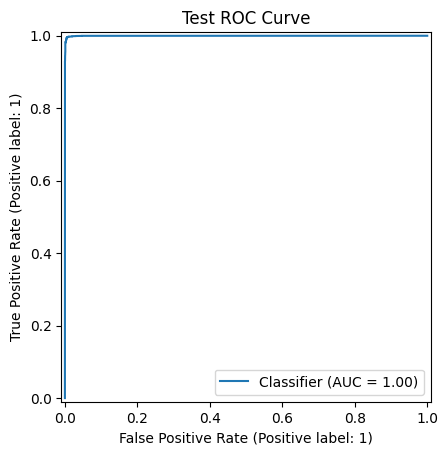

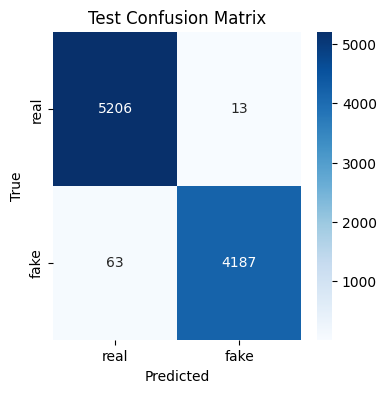

In [23]:
model.load_state_dict(torch.load(MODEL_DIR + "best_model.pt"))
plot_bert_evaluation("Test", model, test_loader, DEVICE)

In [24]:
# External data path
REAL_CSV  = "../data/external/True.csv"
FAKE_CSV  = "../data/external/Fake.csv"

# Load external CSV and combine into a single dataframe
real_news = pd.read_csv(REAL_CSV)
real_news["is_fake"] = 0

fake_news = pd.read_csv(FAKE_CSV)
fake_news["is_fake"] = 1

# Keep only the required columns
real_news = real_news[["title", "text", "is_fake"]]
fake_news = fake_news[["title", "text", "is_fake"]]

# Combine and shuffle the external dataframe
external = pd.concat([real_news, fake_news], ignore_index=True)
external = external.sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Combined external shape:", external.shape)

external.head()

from src.utils import basic_clean, preprocess_text

external["raw_text"] = external["title"].astype(str) + " " + external["text"].astype(str)
external["clean_text"] = external["raw_text"].apply(basic_clean)
external["processed_text"] = external["clean_text"].apply(preprocess_text)
external["is_fake"] = external["is_fake"].astype(int)

# Clean the external data
external.dropna(inplace=True)
external.drop_duplicates(inplace=True)
external.reset_index(drop=True, inplace=True)
external.info()

Combined external shape: (44898, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39105 entries, 0 to 39104
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           39105 non-null  object
 1   text            39105 non-null  object
 2   is_fake         39105 non-null  int32 
 3   raw_text        39105 non-null  object
 4   clean_text      39105 non-null  object
 5   processed_text  39105 non-null  object
dtypes: int32(1), object(5)
memory usage: 1.6+ MB


In [25]:
ext_dataset = TextDataset(
    external.raw_text.values,
    external.is_fake.values,
    tokenizer, MAX_LEN
)
ext_loader = DataLoader(
    ext_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Number of external batches: {len(ext_loader)}")

Number of external batches: 2445



--- External Metrics ---
Accuracy :  0.9993
Precision: 1.0000  Recall: 0.9984  F1: 0.9992
ROC‐AUC  : 1.0000



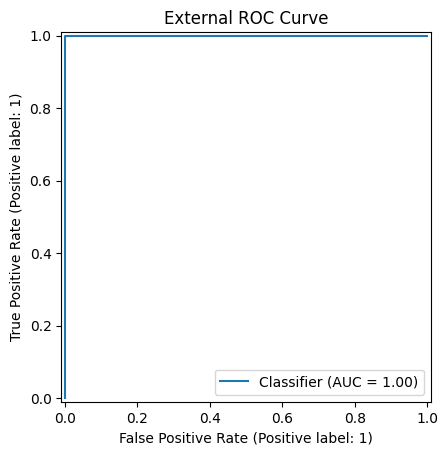

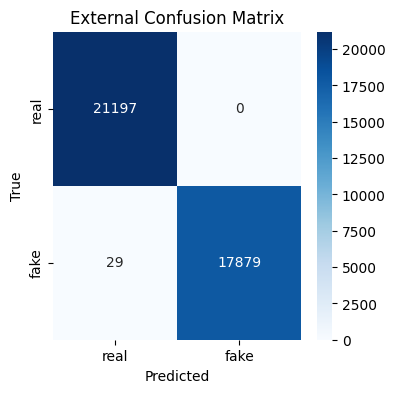

In [26]:
plot_bert_evaluation("External", model, ext_loader, DEVICE)